In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 定义数据处理方法
def preprocess_dataset(data_frame):
    # 先复制产生一个新的数据集，这样我们的原始数据集不会被修改
    data_frame = data_frame.copy()

    # 丢弃缺失年龄，性别和登船口岸信息的数据
    data_frame = data_frame.dropna(subset=['Age', 'Sex', 'Embarked', 'Fare'])

    # 把性别从 male, female 转换成 0 和 1
    data_frame.Sex = data_frame.Sex.replace(['male', 'female'], value=[0, 1])

    # 把登船口岸从 S, C, Q 转换成 0, 1, 2
    data_frame.Embarked = data_frame.Embarked.replace(['S', 'C', 'Q'], value=[0, 1, 2])

    # 丢弃我们不需要的字段
    data_frame = data_frame.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
    return data_frame

# 读取和处理训练数据数据
df = pd.read_csv('data/titanic/train.csv')
train_df = preprocess_dataset(df)

# 拆分特征和标签
train_labels = train_df.pop('Survived')

# 定义模型
from tensorflow.python import keras

# 使用 L 代表 keras.layers ，方便后续调用
L = keras.layers

model = keras.Sequential([
    # 添加一个包含 12 个神经元的全连接层，输入维度为 7，输出维度 12
    L.Dense(12, input_dim=7, activation='relu', name='input_layer'),
    # 添加一个包含 6 个神经元的全连接层，上层的输出为本层的输入
    L.Dense(6, activation='relu', name='hidden_layer'),
    # 添加一个包含 1 个神经元的全连接层，使用 sigmoid 函数来确保网络输出在 0 和 1 之间
    L.Dense(1, activation='sigmoid', name='output_layer')
])

# 编译模型
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 6.2 模型保存和恢复
### 6.2.1 全模型保存

In [8]:
import tensorflow as tf
import os
# 创建目录
os.makedirs('outputs/chapter6', exist_ok=True)

# 保存模型
model.save('outputs/chapter6/my_model.h5')

# 使用保存的文件恢复模型，此时不需要任何之前的代码，只需要这个文件
new_model = tf.keras.models.load_model('outputs/chapter6/my_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 12)                96        
_________________________________________________________________
hidden_layer (Dense)         (None, 6)                 78        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 7         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


### 6.2.2 保存为 SavedModel

In [33]:
# 保存模型为 SavedModel 格式
tf.saved_model.save(model, 'outputs/chapter6/saved_model')
# 加载 SavedModel 模型为 Keras 模型
new_model = tf.keras.models.load_model('outputs/chapter6/saved_model')
!ls outputs/chapter6/saved_model

INFO:tensorflow:Assets written to: outputs/chapter6/saved_model/assets
assets         saved_model.pb variables


### 6.2.3 仅保存模型结构

In [22]:
# 获取模型配置，config 是个 python 字典。
config = model.get_config()

# 使用配置字典重新初始化模型
reinitialized_model = keras.Sequential.from_config(config)

### 6.2.4 仅保存模型权重

In [24]:
weights = model.get_weights()  # 获取模型的权重
model.set_weights(weights)     # 为模型设定权重

# 把权重保存到磁盘
model.save_weights('outputs/chapter6/model_weights.h5')
# 从磁盘加载模型权重
model.load_weights('outputs/chapter6/model_weights.h5')

## 6.3 模型增量更新

In [32]:
# 加载保存模型
new_model = tf.keras.models.load_model('outputs/chapter6/my_model.h5')
# 或加载 SavedModel 格式模型
new_model = tf.keras.models.load_model('outputs/chapter6/saved_model')

# 假数据
new_x = np.random.random((10,7))
new_y = np.random.randint(0, 1, 10)

# 继续调用 fit 训练即可
new_model.fit(new_x, new_y)

Train on 10 samples
10/10 [==============================] - 0s 43ms/sample - loss: 0.7486 - accuracy: 0.4000


## 6.4 训练回调
### 6.4.1 模型检查点和提前终止

In [37]:
import tensorflow as tf

# 当被监测的指标不再提升，则停止训练。
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # 被监测的指标，这里监控模型验证集准确度
    patience=3)              # 如果指标在多余三轮的时间（即四轮）不变后，中断训练

# 在每个训练期之后保存模型。
model_path = 'outputs/chapter6/best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,    # 模型存储路径
    monitor='val_accuracy', # 被监测的指标，这里监控模型验证集准确度
    save_best_only=True)    # 只有指标被改善时候存储，如果为 False，则每一轮保存

model.fit(train_df.values,
          train_labels.values,
          validation_data=(train_df.values, train_labels.values),
          epochs=40,
          callbacks=[early_stop, model_checkpoint])

Train on 712 samples, validate on 712 samples
Epoch 1/40
712/712 [==============================] - 0s 119us/sample - loss: 0.6134 - accuracy: 0.6643 - val_loss: 0.5987 - val_accuracy: 0.6671
Epoch 2/40
712/712 [==============================] - 0s 87us/sample - loss: 0.5976 - accuracy: 0.6643 - val_loss: 0.5894 - val_accuracy: 0.6812
Epoch 3/40
712/712 [==============================] - 0s 71us/sample - loss: 0.5889 - accuracy: 0.6910 - val_loss: 0.5838 - val_accuracy: 0.6812
Epoch 4/40
712/712 [==============================] - 0s 113us/sample - loss: 0.5817 - accuracy: 0.6812 - val_loss: 0.5672 - val_accuracy: 0.6854
Epoch 5/40
712/712 [==============================] - 0s 88us/sample - loss: 0.5855 - accuracy: 0.6854 - val_loss: 0.5606 - val_accuracy: 0.7079
Epoch 6/40
712/712 [==============================] - 0s 83us/sample - loss: 0.5705 - accuracy: 0.7037 - val_loss: 0.5882 - val_accuracy: 0.7374
Epoch 7/40
712/712 [==============================] - 0s 68us/sample - loss: 0.574

### 6.4.2 动态调整学习率

In [40]:
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', # 监控模型的损失
    factor = 0.2,         # 触发时将学习率除以 5
    patience = 10)        # 如果验证损失在 10 轮内都没有改善，那么就触发这个回调函数

model.fit(train_df.values,
          train_labels.values,
          validation_data=(train_df.values, train_labels.values),
          epochs=40,
          callbacks=[reduce_lr_callback])

Train on 712 samples, validate on 712 samples
Epoch 1/40
712/712 [==============================] - 0s 539us/sample - loss: 0.4412 - accuracy: 0.8034 - val_loss: 0.4306 - val_accuracy: 0.7949
Epoch 2/40
712/712 [==============================] - 0s 96us/sample - loss: 0.4378 - accuracy: 0.7978 - val_loss: 0.4429 - val_accuracy: 0.7935
Epoch 3/40
712/712 [==============================] - 0s 90us/sample - loss: 0.4455 - accuracy: 0.7978 - val_loss: 0.4282 - val_accuracy: 0.8118
Epoch 4/40
712/712 [==============================] - 0s 94us/sample - loss: 0.4372 - accuracy: 0.8118 - val_loss: 0.4284 - val_accuracy: 0.8006
Epoch 5/40
712/712 [==============================] - 0s 94us/sample - loss: 0.4862 - accuracy: 0.7879 - val_loss: 0.4357 - val_accuracy: 0.8104
Epoch 6/40
712/712 [==============================] - 0s 93us/sample - loss: 0.4591 - accuracy: 0.8034 - val_loss: 0.4300 - val_accuracy: 0.8216
Epoch 7/40
712/712 [==============================] - 0s 89us/sample - loss: 0.4518

### 6.4.3 自定义回调函数

In [41]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # 训练开始时定义一个数组来保存数据
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        # 把每一轮 batch 的 loss 记录到数组中
        self.losses.append(logs.get('loss'))


loss_history_callback = LossHistory()

model.fit(train_df,
          train_labels,
          epochs=10,
          callbacks=[loss_history_callback])

Train on 712 samples
Epoch 1/10
712/712 [==============================] - 0s 48us/sample - loss: 0.4237 - accuracy: 0.8104
Epoch 2/10
712/712 [==============================] - 0s 71us/sample - loss: 0.4233 - accuracy: 0.8118
Epoch 3/10
712/712 [==============================] - 0s 45us/sample - loss: 0.4234 - accuracy: 0.8090
Epoch 4/10
712/712 [==============================] - 0s 40us/sample - loss: 0.4243 - accuracy: 0.8118
Epoch 5/10
712/712 [==============================] - 0s 46us/sample - loss: 0.4236 - accuracy: 0.8104
Epoch 6/10
712/712 [==============================] - 0s 46us/sample - loss: 0.4243 - accuracy: 0.8076
Epoch 7/10
712/712 [==============================] - 0s 66us/sample - loss: 0.4232 - accuracy: 0.8104
Epoch 8/10
712/712 [==============================] - 0s 49us/sample - loss: 0.4240 - accuracy: 0.8160
Epoch 9/10
712/712 [==============================] - 0s 41us/sample - loss: 0.4235 - accuracy: 0.8104
Epoch 10/10
712/712 [==============================]

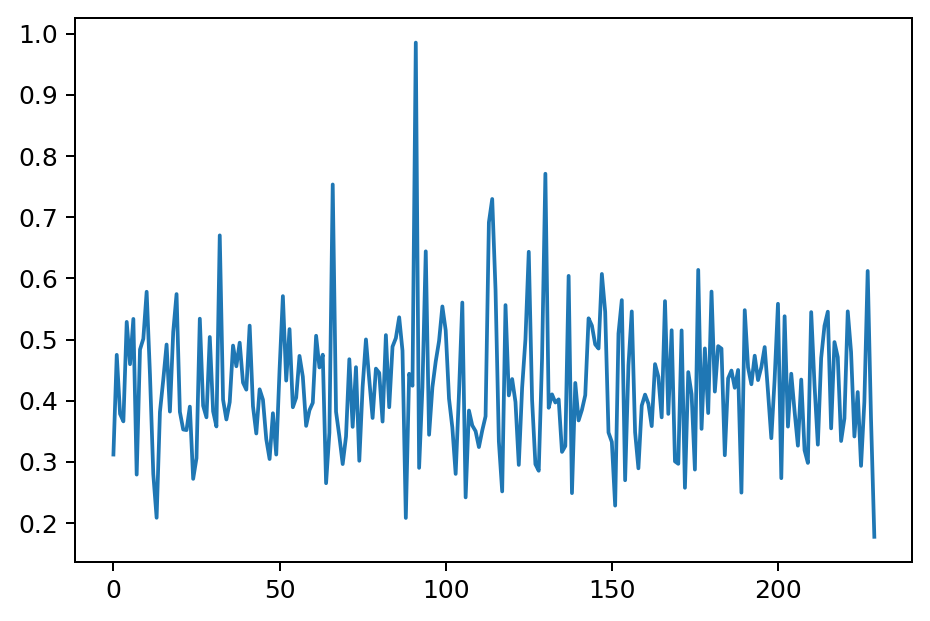

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# 设置 plt 的分辨率，默认分辨率比较低，导致图标不清晰
plt.rcParams['figure.dpi'] = 180

plt.figure()
# 只传入一个参数的话, 默认为 y 轴, x 轴默认为 range(n)
plt.plot(loss_history_callback.losses)
plt.show()

## 6.5 Tensorboard 可视化

In [46]:
tensorboard = keras.callbacks.TensorBoard(
    log_dir='outputs/chapter6/tf_board_log', # 日志输出目录
    histogram_freq=2) # 对于模型中各个层计算激活值和模型权重直方图的频率

model.fit(train_df,
          train_labels,
          epochs=20,
          callbacks=[tensorboard])

Train on 712 samples
Epoch 1/20
712/712 [==============================] - 0s 64us/sample - loss: 0.4232 - accuracy: 0.8090
Epoch 2/20
712/712 [==============================] - 0s 42us/sample - loss: 0.4226 - accuracy: 0.8132
Epoch 3/20
712/712 [==============================] - 0s 49us/sample - loss: 0.4222 - accuracy: 0.8146
Epoch 4/20
712/712 [==============================] - 0s 45us/sample - loss: 0.4257 - accuracy: 0.7978
Epoch 5/20
712/712 [==============================] - 0s 59us/sample - loss: 0.4242 - accuracy: 0.8160
Epoch 6/20
712/712 [==============================] - 0s 51us/sample - loss: 0.4246 - accuracy: 0.8006
Epoch 7/20
712/712 [==============================] - 0s 50us/sample - loss: 0.4221 - accuracy: 0.8132
Epoch 8/20
712/712 [==============================] - 0s 41us/sample - loss: 0.4224 - accuracy: 0.8090
Epoch 9/20
712/712 [==============================] - 0s 49us/sample - loss: 0.4233 - accuracy: 0.8104
Epoch 10/20
712/712 [==============================]